In [5]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, ProductStructureKernel,MaternKernel, GridInterpolationKernel
from gpytorch.distributions import MultivariateNormal
from tqdm import tqdm
global_dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)
device = 'cpu'

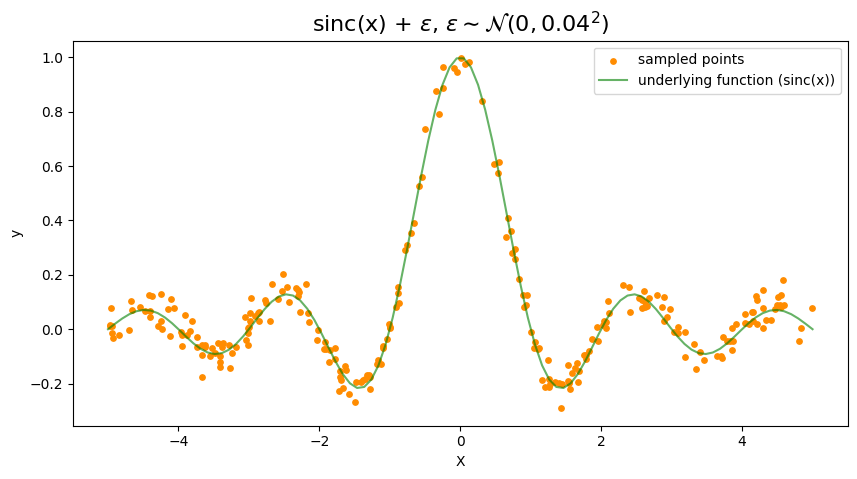

In [6]:
def underlying_function(X):
    base_function = torch.sinc(X)
    noise_std = 0.04
    noise = noise_std * torch.randn_like(X)
    return base_function + noise

n_samples = 250

train_data = torch.sort(10 * torch.rand(n_samples, 1) - 5)[0]
train_labels = underlying_function(train_data)

test_data = torch.linspace(-5, 5, 100).unsqueeze(1)
test_labels_with_noise = underlying_function(test_data)
test_labels = torch.sinc(test_data)

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange',s=15, label='sampled points')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='underlying function (sinc(x))')
plt.xlabel('X')
plt.ylabel('y')
plt.title(r'sinc(x) + $\epsilon$, $\epsilon \sim \mathcal{N}(0, 0.04^2)$', fontsize=16)
plt.legend()
plt.show()


In [7]:
sigma=.05

num_inducing_points = int(train_data.shape[0] * .2)
print("total inducing poitns : ",num_inducing_points)
lengthscale = 0.1 

total inducing poitns :  50


C:\Users\chris\AppData\Local\Temp\ipykernel_28512\2500056898.py:90: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.diag((kiss_cov)))


<Figure size 800x600 with 0 Axes>

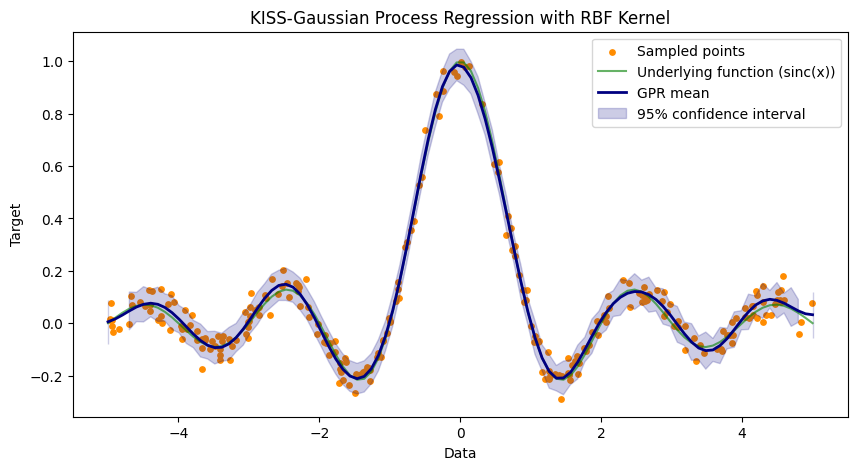

In [9]:

from gpytorch.utils.cholesky import psd_safe_cholesky

class KissGP:
    def __init__(self, lengthscale=1, sigma=0.05, dtype=torch.float64, kernel=MaternKernel, inducing_points=None, degree=3):
        self.sigma = sigma
        self.dtype = dtype
        self.kernel = kernel(lengthscale=lengthscale)
        self.Z = inducing_points.to(dtype=self.dtype)
        self.degree = degree

    def fit(self, X, y):
        self.X_train = X.to(dtype=self.dtype)
        y = y.to(dtype=self.dtype).view(-1, 1)

        self.K_ZZ = self.kernel(self.Z, self.Z).evaluate().to_dense()
        self.W_XZ = self._compute_interpolation_weights(self.X_train, self.Z)

        self.K_XX_approx = self.W_XZ @ self.K_ZZ @ self.W_XZ.T
        self.K_XX_approx += self.sigma ** 2 * torch.eye(len(X), dtype=self.dtype)

        # Using PSD-safe Cholesky decomposition
        self.L = psd_safe_cholesky(self.K_XX_approx)
        self.alpha = torch.cholesky_solve(y, self.L)

    def predict(self, x):
        x = x.to(dtype=self.dtype)
        W_xZ = self._compute_interpolation_weights(x, self.Z)

        prefactor = W_xZ @ self.K_ZZ @ self.W_XZ.T
        common_term = torch.cholesky_solve(prefactor.T, self.L)

        mean = prefactor @ self.alpha

        K_test_test = self.kernel(x, x).evaluate().to_dense()
        covariance = K_test_test - prefactor @ common_term

        jitter = 0
        covariance += jitter * torch.eye(covariance.size(0), dtype=self.dtype)

        return mean.squeeze(), covariance
    
    def _compute_interpolation_weights(self, X, Z):
        weights = []
        for x in X:
            distances = torch.abs(Z - x).squeeze(1)
            if distances.size(0) < self.degree + 1:
                raise RuntimeError(f"Not enough inducing points to interpolate for input {x.item()}")
            closest_points = torch.topk(distances, k=self.degree + 1, largest=False).indices
            z_points = Z[closest_points]
            weights_x = self._polynomial_interpolation_weights(x, z_points)
            w = torch.zeros_like(Z[:, 0])
            for i, idx in enumerate(closest_points):
                w[idx] = weights_x[i]
            weights.append(w)
        return torch.stack(weights)

    def _polynomial_interpolation_weights(self, x, z_points):
        #Lagrange polynomial interpolation
        n = len(z_points)
        weights = torch.zeros(n, dtype=self.dtype)
        for i in range(n):
            xi = z_points[i]
            wi = 1
            for j in range(n):
                if i != j:
                    xj = z_points[j]
                    wi *= (x - xj) / (xi - xj)
            weights[i] = wi
        return weights
    
    def show_weights(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(self.W_XZ, cmap='viridis')
        plt.colorbar(label='W_XZ value')
        plt.title('Covariance Matrix')
        plt.xlabel('Test Points')
        plt.ylabel('Test Points')
        plt.show() 
        
inducing_points = torch.linspace(train_data.min(), train_data.max(), num_inducing_points).unsqueeze(1)

kiss_gpr = KissGP(lengthscale=lengthscale, sigma=sigma, dtype=torch.float64, kernel=RBFKernel, inducing_points=inducing_points,degree=3)
kiss_gpr.fit(train_data, train_labels)

mean, cov = kiss_gpr.predict(test_data)
kiss_mean = mean.detach().numpy()
kiss_cov = cov.detach().numpy()
plt.figure(figsize=(8, 6))

std = np.sqrt(np.diag((kiss_cov)))

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange', s=15,label='Sampled points')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='Underlying function (sinc(x))')
plt.plot(test_data.numpy(), kiss_mean, color='navy', lw=2, label='GPR mean')
plt.fill_between(test_data.ravel(), kiss_mean - 1.96 * std, kiss_mean + 1.96 * std, color='navy', alpha=0.2, label='95% confidence interval')
plt.xlabel('Data')
plt.ylabel('Target')
plt.title('KISS-Gaussian Process Regression with RBF Kernel')
plt.legend()
plt.show()


Frobenius Relative error: 0.0005757035921315026


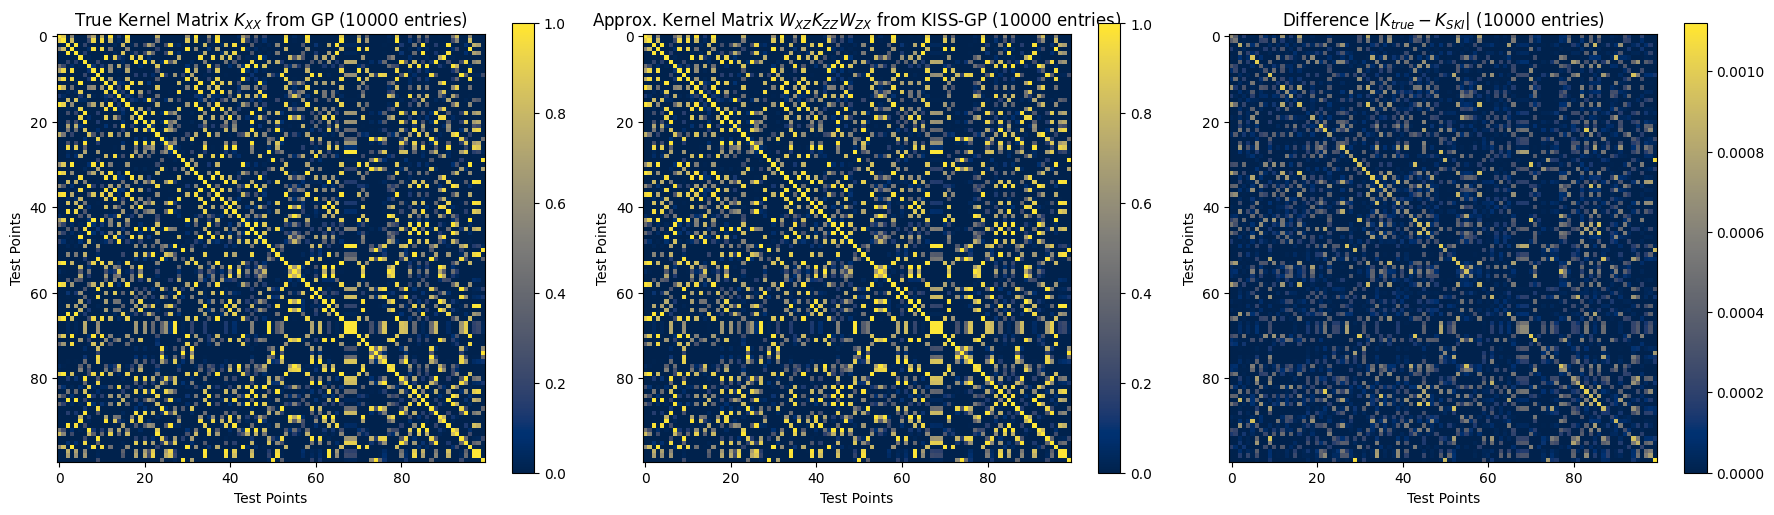

In [11]:
import numpy as np
import matplotlib.pyplot as plt

num_samples = 100  # Define the number of samples to show

K_XX_true = kiss_gpr.kernel(train_data, train_data).evaluate().to_dense().detach().numpy()

K_ZZ = kiss_gpr.K_ZZ
W_XZ = kiss_gpr.W_XZ
approx_K_XX = (W_XZ @ K_ZZ @ W_XZ.T).detach().numpy()

difference_K_XX = np.abs(K_XX_true - approx_K_XX)

frobenius_error = np.linalg.norm(difference_K_XX, 'fro')
frobenius_norm_true = np.linalg.norm(K_XX_true, 'fro')
relative_error = frobenius_error / frobenius_norm_true

print(f'Frobenius Relative error: {relative_error}')

K_XX_true_sample = K_XX_true[:num_samples, :num_samples]
approx_K_XX_sample = approx_K_XX[:num_samples, :num_samples]
difference_K_XX_sample = difference_K_XX[:num_samples, :num_samples]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im0 = axes[0].imshow(K_XX_true_sample, cmap='cividis')
axes[0].set_title(f'True Kernel Matrix $K_{{XX}}$ from GP ({num_samples**2} entries)')
axes[0].set_xlabel('Test Points')
axes[0].set_ylabel('Test Points')
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(approx_K_XX_sample, cmap='cividis')
axes[1].set_title(f'Approx. Kernel Matrix $W_{{XZ}} K_{{ZZ}} W_{{ZX}}$ from KISS-GP ({num_samples**2} entries)')
axes[1].set_xlabel('Test Points')
axes[1].set_ylabel('Test Points')
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(difference_K_XX_sample, cmap='cividis')
axes[2].set_title(f'Difference $|K_{{true}} - K_{{SKI}}|$ ({num_samples**2} entries)')
axes[2].set_xlabel('Test Points')
axes[2].set_ylabel('Test Points')
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()


In [12]:
def to_numpy(data):
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()
    return data

def compare_kernel_spectrums(kernel_true, kernel_approx):
    kernel_true = to_numpy(kernel_true)
    kernel_approx = to_numpy(kernel_approx)

    if kernel_true.shape != kernel_approx.shape:
        raise ValueError("The true and approximate kernel matrices must have the same shape.")
    
    eigvals_true = np.linalg.eigh(kernel_true)[0]
    eigvals_approx = np.linalg.eigh(kernel_approx)[0]

    # Sort eigenvalues in descending order
    eigvals_true_sorted = np.sort(eigvals_true)[::-1]
    eigvals_approx_sorted = np.sort(eigvals_approx)[::-1]

    # Compute Frobenius norm of the difference
    frobenius_norm_diff = np.linalg.norm(kernel_true - kernel_approx, 'fro')
    frobenius_norm_true = np.linalg.norm(kernel_true, 'fro')
    relative_frobenius_norm = frobenius_norm_diff / frobenius_norm_true

    fig, ax = plt.subplots(figsize=(6, 6)) 

    ax.plot(eigvals_true_sorted, label='True Spectrum', color='blue')
    ax.plot(eigvals_approx_sorted, label='Approximate Spectrum', color='orange', linestyle='--')

    ax.axhline(y=relative_frobenius_norm, color='red', linestyle='--', alpha=0.2,label=f'Relative Frobenius Norm of difference : {relative_frobenius_norm:.2e}')

    ax.set_title('True vs Approximate Spectrum')
    ax.set_xlabel('Index')
    ax.set_ylabel('Eigenvalue')
    ax.set_yscale('log')
    ax.legend()

    plt.tight_layout()
    plt.show()


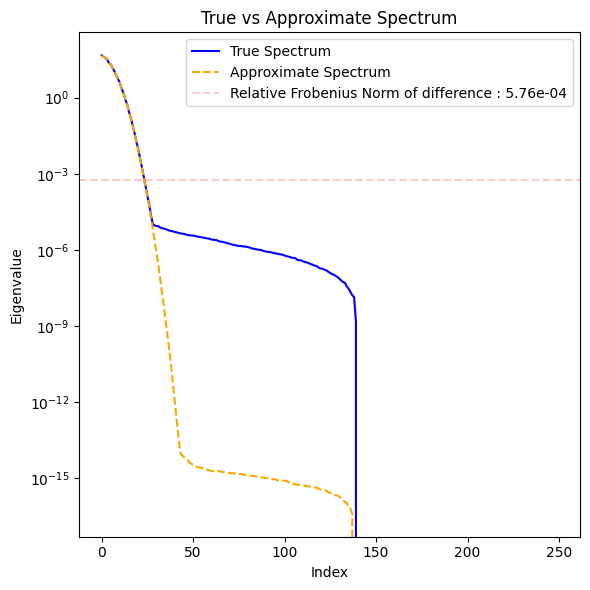

In [13]:
compare_kernel_spectrums(K_XX_true,approx_K_XX)